In [114]:
import pandas as pd
import numpy as np

In [115]:
%pwd

'/Users/IvanTang/quant/IMC_Prosperity3_GraniteFlow/data/round5'

In [116]:
%cd ../../../data/round5/

[Errno 2] No such file or directory: '../../../data/round5/'
/Users/IvanTang/quant/IMC_Prosperity3_GraniteFlow/data/round5


In [117]:
df1 = pd.read_csv('raw/prices.csv')
df2 = pd.read_csv('raw/trades.csv')

In [118]:
df1 = df1[df1['product'] == "MAGNIFICENT_MACARONS"]
df2 = df2[df2['symbol'] == "MAGNIFICENT_MACARONS"]

In [119]:
buyers = list(df2['buyer'].unique())
seller = list(df2['seller'].unique())
#取出trader(买家+卖家的unique)
traders = list(np.union1d(buyers, seller))
print(f"Buyers: {buyers}, Seller: {seller}")

buyers_amount = df2.groupby('buyer')['quantity'].sum()
sellers_amount = df2.groupby('seller')['quantity'].sum()
print(f"Buyers amount: {buyers_amount}, Sellers amount: {sellers_amount}")

Buyers: ['Caesar', 'Paris', 'Camilla', 'Charlie'], Seller: ['Paris', 'Charlie', 'Camilla', 'Caesar']
Buyers amount: buyer
Caesar     1992
Camilla     891
Charlie      58
Paris      2047
Name: quantity, dtype: int64, Sellers amount: seller
Caesar      101
Camilla     870
Charlie    1912
Paris      2105
Name: quantity, dtype: int64


In [120]:
# 初始化持仓记录：{"person": {"symbol": net_position}}
positions = {}

# 存储每个时间点的持仓数据
history = []

# 遍历每一笔交易
for _, row in df2.iterrows():
    timestamp = row["timestamp"]
    buyer = row["buyer"]
    seller = row["seller"]
    symbol = row["symbol"]
    quantity = row["quantity"]
    
    # 初始化 buyer 和 seller 的持仓记录（如果不存在）
    if buyer not in positions:
        positions[buyer] = {}
    if seller not in positions:
        positions[seller] = {}
    if symbol not in positions[buyer]:
        positions[buyer][symbol] = 0
    if symbol not in positions[seller]:
        positions[seller][symbol] = 0
    
    # 更新持仓：
    # buyer 获得 quantity
    positions[buyer][symbol] += quantity
    # seller 减少 quantity
    positions[seller][symbol] -= quantity
    
    # 记录当前持仓状态（可以按需调整，比如每隔一定时间记录）
    history.append({
        "timestamp": timestamp,
        "person": seller,
        "symbol": symbol,
        "position": positions[seller][symbol],
    })

# 转换为 DataFrame
position_history = pd.DataFrame(history)

# 按 person + symbol + timestamp 排序
position_history = position_history.sort_values(["person", "symbol", "timestamp"])


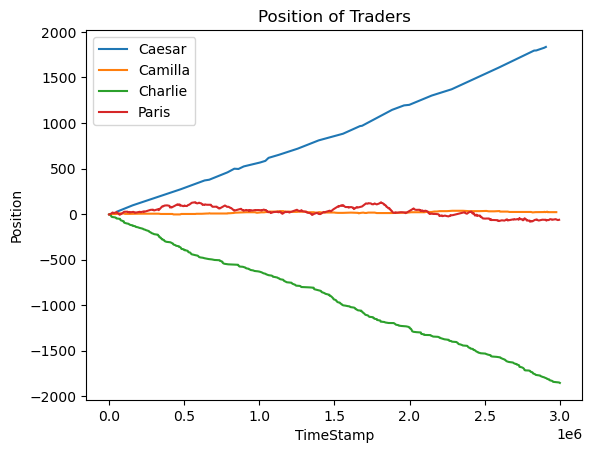

In [121]:
import matplotlib.pyplot as plt

for trader in traders:
    trader_position_history = position_history[position_history['person'] == trader]
    plt.plot(trader_position_history['timestamp'], trader_position_history['position'], label = f"{trader}")
    plt.title('Position of Traders')
    plt.xlabel('TimeStamp')
    plt.ylabel('Position')
    plt.legend()
    

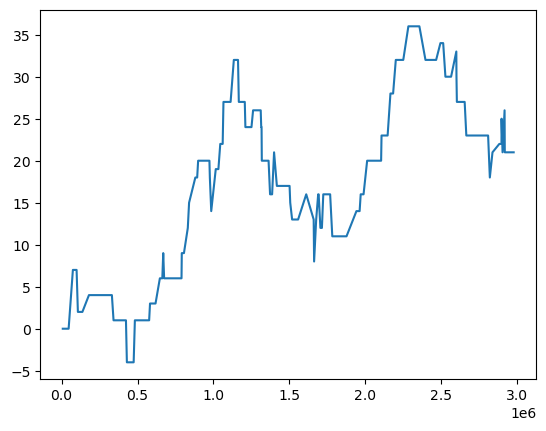

In [122]:
trader_position_history = position_history[position_history['person'] == 'Camilla']
plt.plot(trader_position_history['timestamp'], trader_position_history['position'])

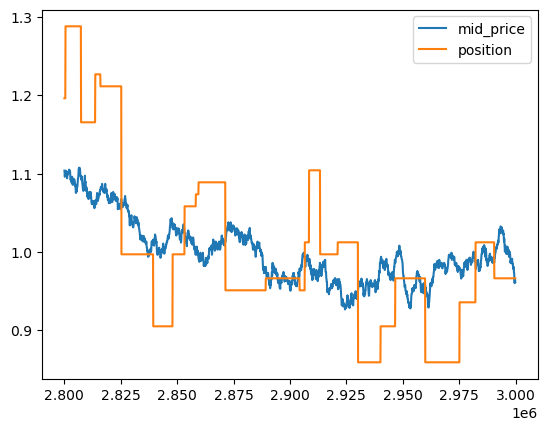

In [125]:
trader = 'Paris'
df1 = df1.sort_values('timestamp')
trader_position_history = position_history[position_history['person'] == trader]
trader_position_history = trader_position_history.sort_values('timestamp')

# 对齐到最近的 position 记录
df_aligned = pd.merge_asof(
    df1[['timestamp', 'mid_price']],
    trader_position_history[['timestamp', 'position']],
    on='timestamp',
    direction='nearest'  # 或 'forward'（向前匹配）
)
time_length = 2000
df_aligned = df_aligned[-time_length:]  # 截取最近的 time_length 时间段
# 归一化绘图
plt.plot(df_aligned['timestamp'], df_aligned['mid_price'] / df_aligned['mid_price'].mean(), label='mid_price')
plt.plot(df_aligned['timestamp'], df_aligned['position'] / df_aligned['position'].mean(), label='position')
plt.legend()

In [48]:
df_aligned

,timestamp,mid_price,position
0,0,657.5,-5
1,100,661.5,-5
2,200,664.5,-5
3,300,669.5,-5
4,400,674.5,-5
...,...,...,...
29995,2999500,745.5,-1854
29996,2999600,741.5,-1854
29997,2999700,745.5,-1854
29998,2999800,744.5,-1854


In [ ]:
#套利机会研究
def orderbook_preprocess(df):
    """
    对订单簿数据进行预处理
    1.填充NAN为0
    2.计算best_bid, best_ask, spread, mid_price, vwap, orderbook_imbalance, ask_bid_ratio
    """
    df = df.copy()
    #填充orderbook数据,nan填为0
    columns = ['ask_price_1', 'ask_volume_1', 'ask_price_2', 'ask_volume_2', 'ask_price_3', 'ask_volume_3', 'bid_price_1', 'bid_volume_1', 'bid_price_2', 'bid_volume_2', 'bid_price_3', 'bid_volume_3']
    for column in columns:
        df[column] = df[column].fillna(0)
    
    #计算best_bid, best_ask, spread, mid_price, vwap
    df['best_bid'] = df[['bid_price_1', 'bid_price_2', 'bid_price_3']].min(axis=1)
    df['best_ask'] = df[['ask_price_1', 'ask_price_2', 'ask_price_3']].max(axis=1)

    #计算best_bid, best_ask

    def get_best_bid_ask_spread(row):
    # 获取有效的买价（去掉NaN） 计算最佳买价
        bid_prices = [row['bid_price_1'], row['bid_price_2'], row['bid_price_3']]
        bid_prices = [price for price in bid_prices if price != 0]
        best_bid = max(bid_prices) if bid_prices else None #最好的买价是最高的买价

        # 获取有效的卖价（去掉NaN） 计算最佳卖价
        ask_prices = [row['ask_price_1'], row['ask_price_2'], row['ask_price_3']]
        ask_prices = [price for price in ask_prices if price != 0]
        best_ask = min(ask_prices) if ask_prices else None #最好的卖价是最低的卖价
        
        # 计算价差
        spread = best_ask - best_bid if best_ask and best_bid else None
        return best_bid, best_ask, spread

    df[['best_bid', 'best_ask','spread']] = df.apply(get_best_bid_ask_spread, axis=1, result_type='expand')

    #计算mid_price 
    df['mid_price'] = (df['ask_price_1']+ df['bid_price_1']) / 2

    #计算vwap
    df['vwap'] = (df['ask_price_1']*df['ask_volume_1'] + df['ask_price_2']*df['ask_volume_2'] + df['ask_price_3']*df['ask_volume_3'] + df['bid_price_1']*df['bid_volume_1'] + df['bid_price_2']*df['bid_volume_2'] + df['bid_price_3']*df['bid_volume_3']) / (df['ask_volume_1'] + df['ask_volume_2'] + df['ask_volume_3'] + df['bid_volume_1'] + df['bid_volume_2'] + df['bid_volume_3'])
    
    #计算orderbook_imbalance
    def orderbook_imbalance(row):
        """ 计算订单簿不平衡度 """
        buy_orders = [(row['bid_price_1'], row['bid_volume_1']), (row['bid_price_2'], row['bid_volume_2']), (row['bid_price_3'], row['bid_volume_3'])]
        sell_orders = [(row['ask_price_1'], row['ask_volume_1']), (row['ask_price_2'], row['ask_volume_2']), (row['ask_price_3'], row['ask_volume_3'])]
        buy_pressure = sum(amount for price, amount in buy_orders if price != 0)
        sell_pressure = sum(amount for price, amount in sell_orders if price != 0)
        total_pressure = buy_pressure + sell_pressure
        if total_pressure == 0:
            return 0
        return (buy_pressure - sell_pressure) / total_pressure
    
    df['orderbook_imbalance'] = df.apply(orderbook_imbalance, axis=1)

    #计算ask_bid_ratio
    df['ask_volume'] = df['ask_volume_1'] + df['ask_volume_2'] + df['ask_volume_3']
    df['bid_volume'] = df['bid_volume_1'] + df['bid_volume_2'] + df['bid_volume_3']
    df['ask_bid_ratio'] = (df['ask_volume'] - df['bid_volume']) / (df['ask_volume'] + df['bid_volume'])
    

    return df
    

In [103]:
df1 = orderbook_preprocess(df1)

In [104]:
df1

,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,...,ask_volume,bid_volume,ask_bid_ratio,bidPrice,askPrice,transportFees,exportTariff,importTariff,sugarPrice,sunlightIndex
0,2,0,MAGNIFICENT_MACARONS,653.0,20.0,651.0,10.0,645.0,21.0,662.0,...,41.0,51.0,-0.108696,657.0,658.5,1.4,10.5,-4.0,209.000000,65.00
1,2,100,MAGNIFICENT_MACARONS,657.0,12.0,654.0,19.0,648.0,26.0,666.0,...,51.0,57.0,-0.055556,660.5,662.0,1.4,10.5,-4.0,209.299299,65.00
2,2,200,MAGNIFICENT_MACARONS,660.0,12.0,658.0,13.0,652.0,30.0,669.0,...,49.0,55.0,-0.057692,664.0,665.5,1.4,10.5,-4.0,209.467113,65.00
3,2,300,MAGNIFICENT_MACARONS,665.0,20.0,663.0,15.0,657.0,27.0,674.0,...,52.0,62.0,-0.087719,669.0,670.5,1.4,10.5,-4.0,209.525592,65.00
4,2,400,MAGNIFICENT_MACARONS,670.0,20.0,667.0,16.0,661.0,25.0,679.0,...,51.0,61.0,-0.089286,673.5,675.0,1.4,10.5,-4.0,209.597333,65.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,4,2999500,MAGNIFICENT_MACARONS,742.0,10.0,740.0,14.0,735.0,21.0,749.0,...,40.0,45.0,-0.058824,745.0,746.5,1.6,7.5,-4.0,206.028012,59.94
29996,4,2999600,MAGNIFICENT_MACARONS,738.0,12.0,736.0,12.0,731.0,28.0,745.0,...,46.0,52.0,-0.061224,741.0,742.5,1.6,7.5,-4.0,205.991170,59.95
29997,4,2999700,MAGNIFICENT_MACARONS,742.0,18.0,740.0,16.0,735.0,29.0,749.0,...,54.0,63.0,-0.076923,744.5,746.0,1.6,7.5,-4.0,206.053141,59.96
29998,4,2999800,MAGNIFICENT_MACARONS,741.0,10.0,739.0,20.0,734.0,27.0,748.0,...,52.0,57.0,-0.045872,744.0,745.5,1.6,7.5,-4.0,205.751795,59.98


In [97]:
df_obs = pd.read_csv('raw/obs.csv')

In [100]:
df1 = pd.merge(df1, df_obs, on = 'timestamp' )

In [101]:
df1

,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,...,ask_volume,bid_volume,ask_bid_ratio,bidPrice,askPrice,transportFees,exportTariff,importTariff,sugarPrice,sunlightIndex
0,2,0,MAGNIFICENT_MACARONS,653.0,20.0,651.0,10.0,645.0,21.0,662.0,...,41.0,51.0,-0.108696,657.0,658.5,1.4,10.5,-4.0,209.000000,65.00
1,2,100,MAGNIFICENT_MACARONS,657.0,12.0,654.0,19.0,648.0,26.0,666.0,...,51.0,57.0,-0.055556,660.5,662.0,1.4,10.5,-4.0,209.299299,65.00
2,2,200,MAGNIFICENT_MACARONS,660.0,12.0,658.0,13.0,652.0,30.0,669.0,...,49.0,55.0,-0.057692,664.0,665.5,1.4,10.5,-4.0,209.467113,65.00
3,2,300,MAGNIFICENT_MACARONS,665.0,20.0,663.0,15.0,657.0,27.0,674.0,...,52.0,62.0,-0.087719,669.0,670.5,1.4,10.5,-4.0,209.525592,65.00
4,2,400,MAGNIFICENT_MACARONS,670.0,20.0,667.0,16.0,661.0,25.0,679.0,...,51.0,61.0,-0.089286,673.5,675.0,1.4,10.5,-4.0,209.597333,65.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,4,2999500,MAGNIFICENT_MACARONS,742.0,10.0,740.0,14.0,735.0,21.0,749.0,...,40.0,45.0,-0.058824,745.0,746.5,1.6,7.5,-4.0,206.028012,59.94
29996,4,2999600,MAGNIFICENT_MACARONS,738.0,12.0,736.0,12.0,731.0,28.0,745.0,...,46.0,52.0,-0.061224,741.0,742.5,1.6,7.5,-4.0,205.991170,59.95
29997,4,2999700,MAGNIFICENT_MACARONS,742.0,18.0,740.0,16.0,735.0,29.0,749.0,...,54.0,63.0,-0.076923,744.5,746.0,1.6,7.5,-4.0,206.053141,59.96
29998,4,2999800,MAGNIFICENT_MACARONS,741.0,10.0,739.0,20.0,734.0,27.0,748.0,...,52.0,57.0,-0.045872,744.0,745.5,1.6,7.5,-4.0,205.751795,59.98


In [112]:
#寻找套利机会
#进口：在岛外买在岛内卖
df1['importProfit'] = df1['best_bid'] - (df1['askPrice'] + df1['importTariff'] + df1['transportFees'])
df1['exportProfit'] = df1['best_ask'] - df1['exportTariff'] - df1['transportFees'] - df1['bidPrice']
df1['spread'] = df1['best_ask'] - df1['best_bid']
df1['cost'] = df1['importTariff'] + df1['exportTariff'] + 2 * df1['transportFees']
df1['arbitageProfit'] = df1['spread'] - df1['cost']


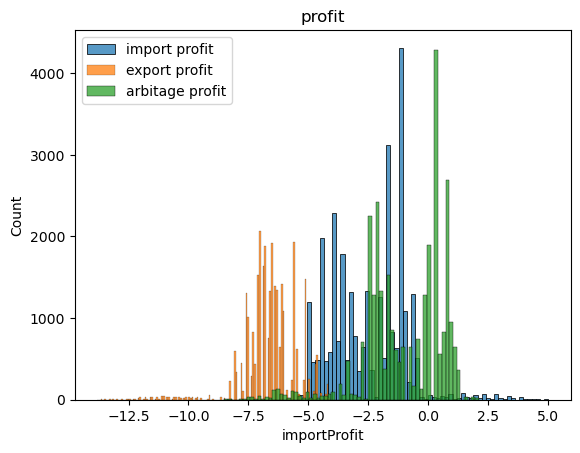

In [113]:
import seaborn as sns
sns.histplot(df1['importProfit'], label = 'import profit')
sns.histplot(df1['exportProfit'], label = 'export profit')
sns.histplot(df1['arbitageProfit'], label = 'arbitage profit')
plt.title('profit')
plt.legend()